In [2]:
import pandas as pd
import torch
import os
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the dataset
file_path = os.getcwd()+'/preprocessing.csv'
data = pd.read_csv(file_path)

# Encode the target variable F1
label_encoder = LabelEncoder()
data['F1_encoded'] = label_encoder.fit_transform(data['F1'])

# Extract the features and target
X = data['grid_path'].tolist()
y = data['F1_encoded'].tolist()

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset class for our data
class GridPathDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16

# Create dataset
dataset = GridPathDataset(X, y, tokenizer, MAX_LEN)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model training setup
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

print("Training complete.")

# Evaluation
model.eval()
val_targets = []
val_predictions = []

with torch.no_grad():
    
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        val_targets.extend(labels.cpu().numpy())
        val_predictions.extend(preds.cpu().numpy())

# Calculate performance metrics
accuracy = accuracy_score(val_targets, val_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_predictions, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1 Score: {f1:.4f}')

# Save the model
model.save_pretrained('./bert-classification-model')
tokenizer.save_pretrained('./bert-classification-tokenizer')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch: 0, Loss: 0.7046003937721252
Epoch: 0, Loss: 0.29321151971817017
Epoch: 0, Loss: 0.308997243642807
Epoch: 0, Loss: 0.59018474817276
Epoch: 0, Loss: 0.38808318972587585
Epoch: 0, Loss: 0.32617413997650146
Epoch: 0, Loss: 0.3818863034248352
Epoch: 0, Loss: 0.24665364623069763
Epoch: 0, Loss: 0.19962812960147858
Epoch: 0, Loss: 0.1469956636428833
Epoch: 0, Loss: 0.06827922910451889
Epoch: 0, Loss: 0.15583564341068268
Epoch: 0, Loss: 0.35108786821365356
Epoch: 0, Loss: 0.19213221967220306
Epoch: 0, Loss: 0.04761192575097084
Epoch: 0, Loss: 0.17993587255477905
Epoch: 0, Loss: 0.02243957296013832
Epoch: 0, Loss: 0.10852734744548798
Epoch: 0, Loss: 0.5431343913078308
Epoch: 0, Loss: 0.2503432035446167
Epoch: 0, Loss: 0.07736983895301819
Epoch: 0, Loss: 0.26740533113479614
Epoch: 0, Loss: 0.20058687031269073
Epoch: 1, Loss: 0.24405044317245483
Epoch: 1, Loss: 0.009687426500022411
Epoch: 1, Loss: 0.037213221192359924
Epoch: 1, Loss: 0.042315252125263214
Epoch: 1, Loss: 0.07673197984695435

('./bert-classification-tokenizer\\tokenizer_config.json',
 './bert-classification-tokenizer\\special_tokens_map.json',
 './bert-classification-tokenizer\\vocab.txt',
 './bert-classification-tokenizer\\added_tokens.json')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch: 0, Loss: 0.6641759276390076
Epoch: 0, Loss: 0.32679155468940735
Epoch: 0, Loss: 0.3807682693004608
Epoch: 0, Loss: 0.6214563846588135
Epoch: 0, Loss: 0.2570272386074066
Epoch: 0, Loss: 0.44539302587509155
Epoch: 0, Loss: 0.424823522567749
Epoch: 0, Loss: 0.27012312412261963
Epoch: 0, Loss: 0.27525585889816284
Epoch: 0, Loss: 0.392438679933548
Epoch: 0, Loss: 0.2422669231891632
Epoch: 0, Loss: 0.2794155180454254
Epoch: 0, Loss: 0.16546575725078583
Epoch: 0, Loss: 0.16743475198745728
Epoch: 0, Loss: 0.3360508382320404
Epoch: 0, Loss: 0.18037523329257965
Epoch: 0, Loss: 0.36529603600502014
Epoch: 0, Loss: 0.35613390803337097
Epoch: 0, Loss: 0.12896502017974854
Epoch: 0, Loss: 0.24177126586437225
Epoch: 0, Loss: 0.15172037482261658
Epoch: 0, Loss: 0.0960768312215805
Epoch: 0, Loss: 0.11344822496175766
Epoch: 1, Loss: 0.1048884391784668
Epoch: 1, Loss: 0.1511075347661972
Epoch: 1, Loss: 0.09514636546373367
Epoch: 1, Loss: 0.009373068809509277
Epoch: 1, Loss: 0.10454391688108444
Epoch

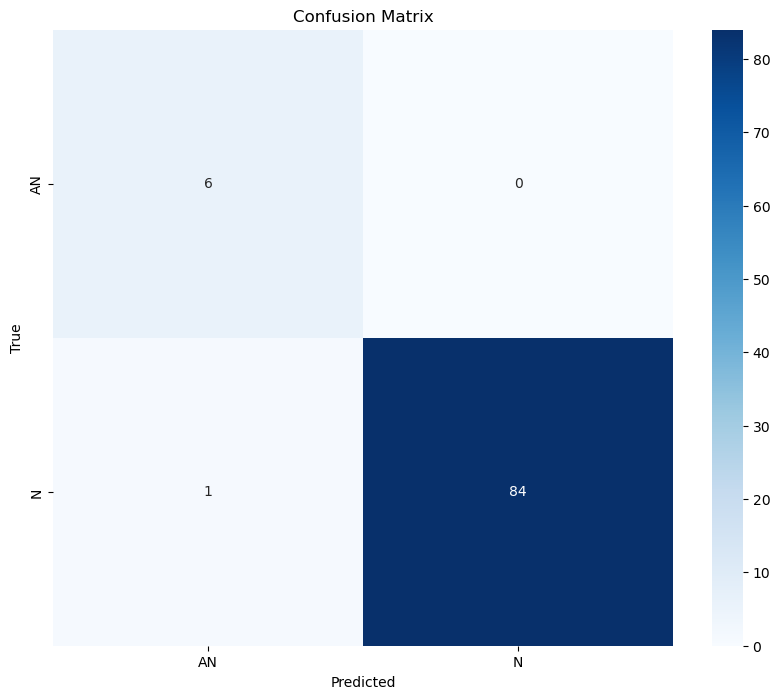

('./bert-classification-tokenizer\\tokenizer_config.json',
 './bert-classification-tokenizer\\special_tokens_map.json',
 './bert-classification-tokenizer\\vocab.txt',
 './bert-classification-tokenizer\\added_tokens.json')

In [53]:
import pandas as pd
import torch
import os
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = os.getcwd() + '/preprocessing.csv'
data = pd.read_csv(file_path)

# Encode the target variable F1
label_encoder = LabelEncoder()
data['F1_encoded'] = label_encoder.fit_transform(data['F1'])

# Extract the features and target
X = data['grid_path'].tolist()
y = data['F1_encoded'].tolist()

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset class for our data
class GridPathDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128 #86
BATCH_SIZE = 16

# Create dataset
dataset = GridPathDataset(X, y, tokenizer, MAX_LEN)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model training setup
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

print("Training complete.")

# Evaluation
model.eval()
val_targets = []
val_predictions = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        val_targets.extend(labels.cpu().numpy())
        val_predictions.extend(preds.cpu().numpy())

# Calculate performance metrics
accuracy = accuracy_score(val_targets, val_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_predictions, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(val_targets, val_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model
model.save_pretrained('./bert-classification-model')
tokenizer.save_pretrained('./bert-classification-tokenizer')


In [54]:
print(val_targets)
print(val_predictions)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
